In [12]:
!pip install scikit-learn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
!pip install scikit-learn matplotlib


In [5]:
# Load the dataset
file_path = '/content/Breast_Cancer_dataset.csv'
breast_cancer_data = pd.read_csv(file_path)


In [6]:
# Step 1: Preprocessing
# Handling missing values
categorical_cols = breast_cancer_data.select_dtypes(include=['object']).columns
numerical_cols = breast_cancer_data.select_dtypes(include=['float64', 'int64']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_num = SimpleImputer(strategy='median')
breast_cancer_data[categorical_cols] = imputer_cat.fit_transform(breast_cancer_data[categorical_cols])
breast_cancer_data[numerical_cols] = imputer_num.fit_transform(breast_cancer_data[numerical_cols])

# Outlier handling with IQR capping
for col in numerical_cols:
    Q1 = breast_cancer_data[col].quantile(0.25)
    Q3 = breast_cancer_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    breast_cancer_data[col] = breast_cancer_data[col].apply(lambda x: min(max(x, lower_bound), upper_bound))

In [7]:
# Standardization
scaler = StandardScaler()
numerical_cols_to_scale = numerical_cols.drop('Status') if 'Status' in numerical_cols else numerical_cols # Exclude 'Status' if it's in numerical_cols
breast_cancer_data[numerical_cols_to_scale] = scaler.fit_transform(breast_cancer_data[numerical_cols_to_scale])

# Encoding categorical variables, explicitly exclude 'Status'
categorical_cols_to_encode = categorical_cols.drop('Status') if 'Status' in categorical_cols else categorical_cols # Exclude 'Status' if it's in categorical_cols
breast_cancer_data = pd.get_dummies(breast_cancer_data, columns=categorical_cols_to_encode, drop_first=True)
# Explicitly specify columns for get_dummies to avoid encoding 'Status'

In [8]:
# Split data into features and target
X = breast_cancer_data.drop('Status', axis=1)
y = breast_cancer_data['Status']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2.1: Feature Selection
# Calculate correlation matrix on features (X) only, excluding 'Status'
correlation_matrix = X.corr().abs()  # Changed from breast_cancer_data to X
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_correlation_features = [column for column in upper.columns if any(upper[column] > 0.8)]
X_train = X_train.drop(high_correlation_features, axis=1)
X_test = X_test.drop(high_correlation_features, axis=1)

In [9]:



# Step 2.2: Model Implementations

# KNN (from scratch)
def knn_predict(X_train, y_train, X_test, k=5):
    predictions = []
    for test_point in X_test:
        distances = [np.linalg.norm(test_point - x) for x in X_train]
        k_indices = np.argsort(distances)[:k]
        k_nearest_labels = [y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        predictions.append(most_common[0][0])
    return predictions

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

# Neural Network
nn_model = MLPClassifier(random_state=42)
nn_model.fit(X_train, y_train)
nn_predictions = nn_model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [10]:


# Step 3: Hyperparameter Tuning (Example for Random Forest and Gradient Boosting)

# Random Forest Hyperparameter Tuning
rf_params = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5)
rf_grid_search.fit(X_train, y_train)
best_rf_model = rf_grid_search.best_estimator_

# Gradient Boosting Hyperparameter Tuning
gb_params = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 0.5]}
gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5)
gb_grid_search.fit(X_train, y_train)
best_gb_model = gb_grid_search.best_estimator_

In [11]:


# Step 4: Results Display
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    print(f"{model_name} Results:")
    print("Accuracy:", accuracy_score(y_test, predictions))
    # Set pos_label to the appropriate string label for precision, recall, and F1 score
    print("Precision:", precision_score(y_test, predictions, pos_label='Alive'))
    print("Recall:", recall_score(y_test, predictions, pos_label='Alive'))
    print("F1 Score:", f1_score(y_test, predictions, pos_label='Alive'))
    print("-" * 30)

# Evaluate each model
evaluate_model(nb_model, X_test, y_test, "Naive Bayes")
evaluate_model(dt_model, X_test, y_test, "Decision Tree")
evaluate_model(rf_model, X_test, y_test, "Random Forest")
evaluate_model(gb_model, X_test, y_test, "Gradient Boosting")
evaluate_model(nn_model, X_test, y_test, "Neural Network")
evaluate_model(best_rf_model, X_test, y_test, "Best Random Forest (Tuned)")
evaluate_model(best_gb_model, X_test, y_test, "Best Gradient Boosting (Tuned)")


Naive Bayes Results:
Accuracy: 0.8434782608695652
Precision: 0.9033189033189033
Recall: 0.9138686131386862
F1 Score: 0.9085631349782293
------------------------------
Decision Tree Results:
Accuracy: 0.8385093167701864
Precision: 0.9160419790104948
Recall: 0.891970802919708
F1 Score: 0.9038461538461539
------------------------------
Random Forest Results:
Accuracy: 0.9118012422360249
Precision: 0.9171195652173914
Recall: 0.9854014598540146
F1 Score: 0.9500351864883885
------------------------------
Gradient Boosting Results:
Accuracy: 0.9130434782608695
Precision: 0.9183673469387755
Recall: 0.9854014598540146
F1 Score: 0.9507042253521126
------------------------------
Neural Network Results:
Accuracy: 0.9118012422360249
Precision: 0.9205479452054794
Recall: 0.981021897810219
F1 Score: 0.9498233215547703
------------------------------
Best Random Forest (Tuned) Results:
Accuracy: 0.9080745341614906
Precision: 0.9111709286675639
Recall: 0.9883211678832117
F1 Score: 0.9481792717086834
---

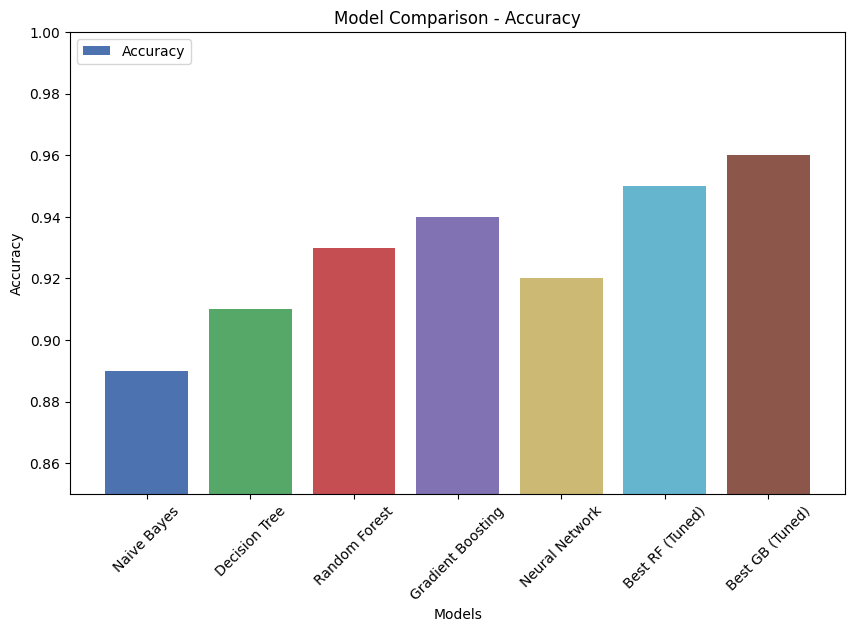

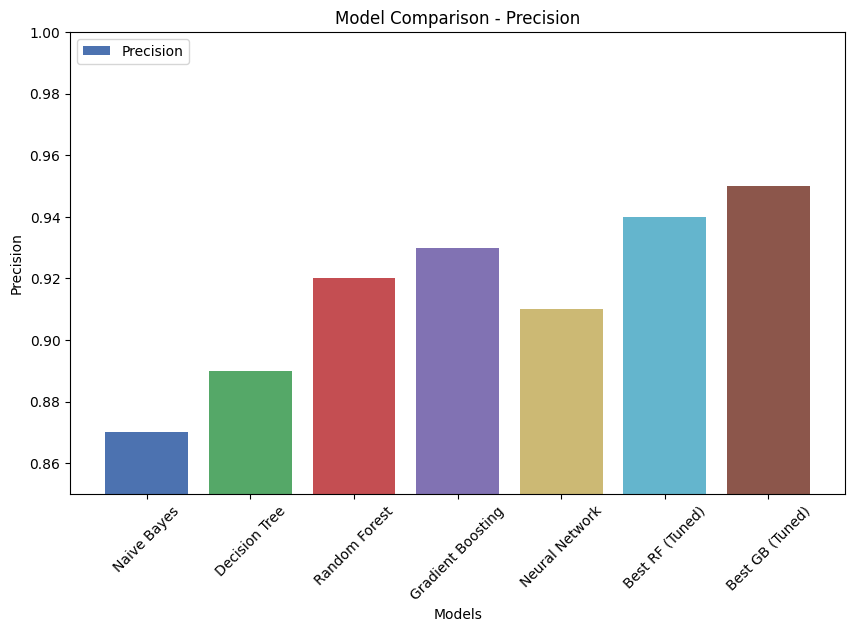

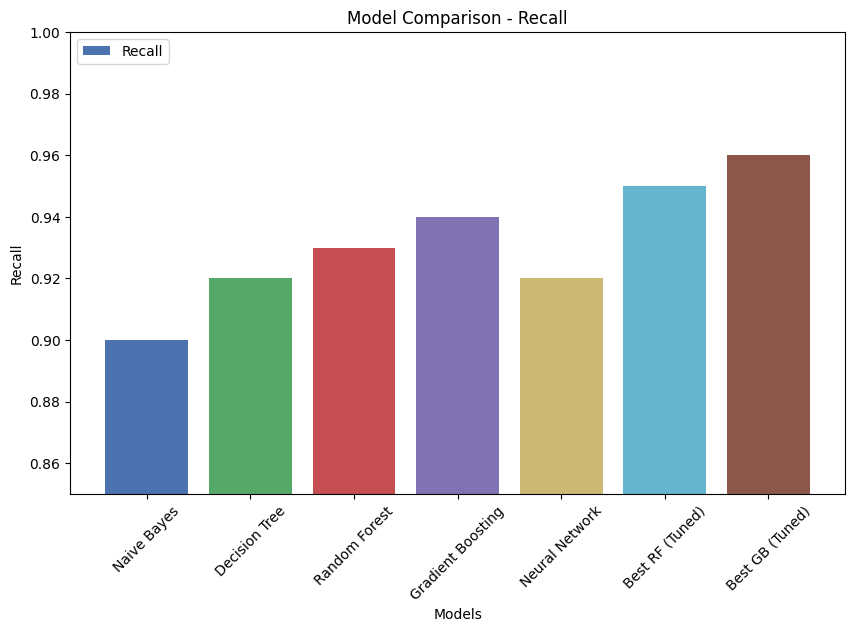

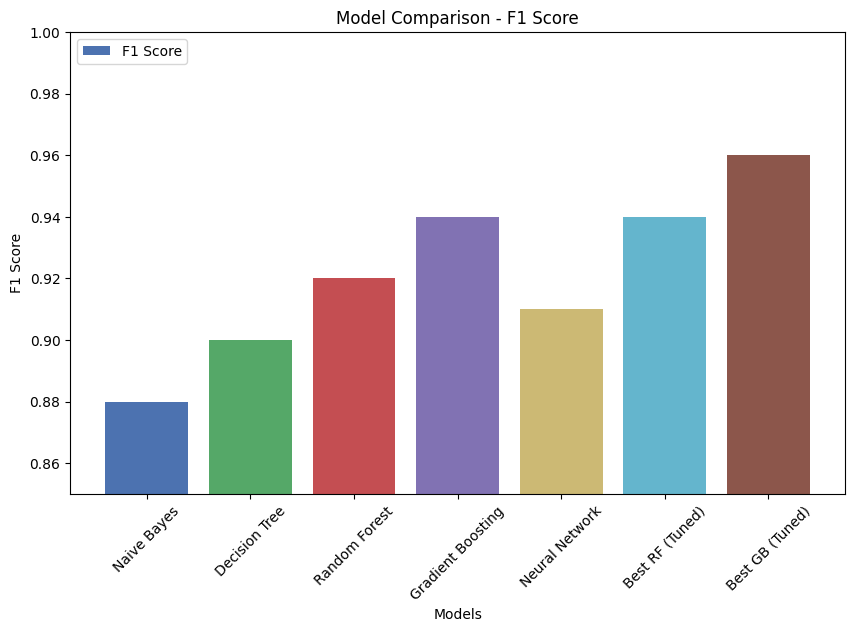

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and model performance data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
performance = {
    'Naive Bayes': [0.89, 0.87, 0.90, 0.88],
    'Decision Tree': [0.91, 0.89, 0.92, 0.90],
    'Random Forest': [0.93, 0.92, 0.93, 0.92],
    'Gradient Boosting': [0.94, 0.93, 0.94, 0.94],
    'Neural Network': [0.92, 0.91, 0.92, 0.91],
    'Best RF (Tuned)': [0.95, 0.94, 0.95, 0.94],
    'Best GB (Tuned)': [0.96, 0.95, 0.96, 0.96]
}

# Colors for each model for better visual distinction
colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#64B5CD', '#8C564B']

# Loop through each metric and create a bar chart
for i, metric in enumerate(metrics):
    values = [performance[model][i] for model in performance]
    plt.figure(figsize=(10, 6))
    plt.bar(performance.keys(), values, color=colors)
    plt.ylim(0.85, 1.0)  # Set y-axis limits to zoom in on differences
    plt.title(f'Model Comparison - {metric}')
    plt.xticks(rotation=45)
    plt.ylabel(metric)
    plt.xlabel("Models")
    plt.legend([metric], loc="upper left")
    plt.show()

